In [3]:
!pip install pandas

     --------------------------------------- 10.8/10.8 MB 11.7 MB/s eta 0:00:00
     --------------------------------------- 15.8/15.8 MB 10.7 MB/s eta 0:00:00
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)
     ------------------------------------- 341.8/341.8 KB 10.4 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\SSAFY\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [9]:
!pip install scikit-learn

     ---------------------------------------- 9.3/9.3 MB 11.5 MB/s eta 0:00:00
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
     ---------------------------------------- 44.3/44.3 MB 9.6 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\SSAFY\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import glob

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

# CSV 파일들을 저장할 빈 DataFrame을 생성합니다.
stock = pd.DataFrame()

# data 폴더에 있는 모든 CSV 파일을 가져옵니다.
csv_files = glob.glob('data/*.csv')

# 모든 CSV 파일을 순회하며 데이터를 DataFrame에 추가합니다.
for csv_file in csv_files:
    tmp = pd.read_csv(csv_file)
    stock = pd.concat([stock, tmp], ignore_index=True)

# all_data DataFrame에 모든 CSV 파일의 내용이 포함됩니다.
# Date,Open,High,Low,Close,Volume,Change,ma5,ma10,ma20,Kospi,S&P500,rsi,%K,%D,bb_upper,bb_sma,bb_lower,volume_ma5,momentum,high_low_diff

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from itertools import combinations

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import load_model


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
# 'Close', 'Open', 'High', 'Low', ' Close', 'ma10', 'ma20', 'rsi', '%K', '%D', 'bb_upper', 'bb_sma', 'bb_lower', 'volume_ma5', 'momentum', 'high_low_diff'
use_cols = ['Open', 'High', 'Low','Close','Volume']

colList = ['ma10', 'ma20', 'S&P500','Kospi', 'rsi', '%K', '%D', 'bb_upper', 'bb_lower', 'volume_ma5', 'momentum', 'high_low_diff']
# Date,Open,High,Low,Close,Volume,Change,ma5,ma10,ma20,rsi,%K,%D,bb_upper,bb_sma,bb_lower,volume_ma5,momentum,high_low_diff
result_pridict = []
com_colList = []

for r in range(2,3):
    # colList의 요소들 중 r개를 선택하는 모든 조합 생성
    for combination in combinations(colList, r):
        com_colList.append(list(combination))
print(com_colList)

for plus_cols in com_colList:
    use_cols.extend(plus_cols)
    
    # 스케일 후 columns
    scaled = scaler.fit_transform(stock[use_cols])
    scaled
    df = pd.DataFrame(scaled, columns=use_cols)

    ln_use_cols = len(use_cols)
    WINDOW_SIZE = 20    
    BATCH_SIZE = 100

    X, y = [], []

    for i in range(WINDOW_SIZE, len(scaled)):
        X.append(scaled[i - WINDOW_SIZE:i])
        y.append([scaled[i]])

    X, y = np.array(X), np.array(y)

    # 데이터를 훈련 세트와 테스트 세트로 나눕니다.
    split_ratio = 0.8  # 예시로 80%를 훈련 데이터로 사용
    split_index = int(split_ratio * len(X))

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]


    # LSTM 모델 설정
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=(WINDOW_SIZE, ln_use_cols)),
        Dense(32, activation='relu'),
        Dense(ln_use_cols)  # 예측할 feature 개수
    ])

    # 모델 컴파일
    loss = Huber()
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss=loss, optimizer=optimizer)

    # Early Stopping 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    tmp = '_'.join(use_cols[5:])
    # Model Checkpoint 설정
    checkpoint = ModelCheckpoint(
        filepath=f'./checkpoint/LSTM/LSTM_{tmp}.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # 모델 학습
    history = model.fit(
        X_train,  # 훈련 데이터
        y_train,  # 레이블
        validation_split=0.2,  # 검증 데이터 비율
        epochs=50,  # 에포크 횟수
        callbacks=[early_stopping, checkpoint],  # Early Stopping과 Model Checkpoint 콜백
        batch_size=32  # 배치 크기
    )
    input_scaled = stock[use_cols]

    total_data =[[input_scaled[len(input_scaled)-WINDOW_SIZE-1:len(input_scaled)-1]]]
    conform_total_data =[[input_scaled[len(input_scaled)-1:len(input_scaled)]]][:4]
    print(total_data)
    print(conform_total_data)

    # total_data를 2D 배열로 변환
    data = np.array(total_data)
    # 2D 배열을 리스트로 변환
    data = data.tolist()

    # 데이터만 포함된 행렬 생성
    data = data[0]

    # data_matrix 출력
    # print(data)
    # print(len(data[0]))
    conform_data = conform_total_data[0][0] # 마지막 데이터를 변수에 할당
    conform_data = conform_data.values[0]  # 데이터 확인용 

    # 3D 배열을 2D로 변환
    data_2d = np.array(data).reshape(-1, len(data[0][0]))  # 하위 리스트의 길이를 사용

    # Min-Max 스케일러 생성
    scaler = MinMaxScaler()
    scaler.fit(data_2d)

    # 주어진 데이터를 스케일링
    scaled_data_2d = scaler.transform(data_2d)

    # 2D 배열을 3D로 다시 변환
    scaled_data_3d = scaled_data_2d.reshape(len(data), len(data[0]), len(data[0][0]))  # 원래 형태로 다시 변환
    model = load_model(f'./checkpoint/LSTM/LSTM_{tmp}.h5')
    # 모델로부터의 예측 결과 (여기에서 모델 예측을 수행해야 함)
    predicted_value = model.predict(scaled_data_3d)  # 모델에 스케일링된 데이터를 입력

    # 예측값을 스케일링 전의 원래 값으로 역 스케일링
    predicted_value_original = scaler.inverse_transform(predicted_value)
    # print(predicted_value_original)
    predicted_value_original = np.round(predicted_value_original, ln_use_cols)[0][:4]
    # print("예측결과",predicted_value_original)
    conform_total_data =conform_total_data[0][0].values[0]
    # print("넣은 데이터",conform_total_data)
    predicted_value_original = list(predicted_value_original)
    predicted_value_original.extend(conform_total_data[:4])
    # print(conform_total_data, "컨텀 토탈")
    use_cols_check = '/'.join(use_cols)
    predicted_value_original.append(use_cols_check)
    result_use_cols = use_cols[:4]
    result_use_cols.extend(['_Open', '_High', '_Low','_Close', 'Use_Cols_Check'])
    # print(result_use_cols)
    print(predicted_value_original)
    result_dict = dict(zip(result_use_cols, predicted_value_original))
    result_pridict.append(result_dict)
    print(use_cols)
    use_cols = use_cols[:5]  # 초기 use_cols로 재설정




[['ma10', 'ma20'], ['ma10', 'S&P500'], ['ma10', 'Kospi'], ['ma10', 'rsi'], ['ma10', '%K'], ['ma10', '%D'], ['ma10', 'bb_upper'], ['ma10', 'bb_lower'], ['ma10', 'volume_ma5'], ['ma10', 'momentum'], ['ma10', 'high_low_diff'], ['ma20', 'S&P500'], ['ma20', 'Kospi'], ['ma20', 'rsi'], ['ma20', '%K'], ['ma20', '%D'], ['ma20', 'bb_upper'], ['ma20', 'bb_lower'], ['ma20', 'volume_ma5'], ['ma20', 'momentum'], ['ma20', 'high_low_diff'], ['S&P500', 'Kospi'], ['S&P500', 'rsi'], ['S&P500', '%K'], ['S&P500', '%D'], ['S&P500', 'bb_upper'], ['S&P500', 'bb_lower'], ['S&P500', 'volume_ma5'], ['S&P500', 'momentum'], ['S&P500', 'high_low_diff'], ['Kospi', 'rsi'], ['Kospi', '%K'], ['Kospi', '%D'], ['Kospi', 'bb_upper'], ['Kospi', 'bb_lower'], ['Kospi', 'volume_ma5'], ['Kospi', 'momentum'], ['Kospi', 'high_low_diff'], ['rsi', '%K'], ['rsi', '%D'], ['rsi', 'bb_upper'], ['rsi', 'bb_lower'], ['rsi', 'volume_ma5'], ['rsi', 'momentum'], ['rsi', 'high_low_diff'], ['%K', '%D'], ['%K', 'bb_upper'], ['%K', 'bb_lower']

In [8]:

print(result_pridict)
import pandas as pd


# 데이터를 DataFrame으로 변환
df = pd.DataFrame(result_pridict)

# DataFrame을 엑셀 파일로 저장
df.to_excel('LSTM_result_pridict2.xlsx', index=False)







[{'Open': 872607.7, 'High': 885758.3, 'Low': 847465.7, 'Close': 868226.94, '_Open': 947776.0, '_High': 947776.0, '_Low': 885513.0, '_Close': 892432.0, 'Use_Cols_Check': 'Open/High/Low/Close/Volume/ma10'}, {'Open': 873255.94, 'High': 887038.4, 'Low': 849376.8, 'Close': 870182.9, '_Open': 947776.0, '_High': 947776.0, '_Low': 885513.0, '_Close': 892432.0, 'Use_Cols_Check': 'Open/High/Low/Close/Volume/ma20'}, {'Open': 872929.7, 'High': 889275.25, 'Low': 847878.9, 'Close': 869393.25, '_Open': 947776.0, '_High': 947776.0, '_Low': 885513.0, '_Close': 892432.0, 'Use_Cols_Check': 'Open/High/Low/Close/Volume/S&P500'}, {'Open': 873247.56, 'High': 888487.8, 'Low': 846898.3, 'Close': 869974.6, '_Open': 947776.0, '_High': 947776.0, '_Low': 885513.0, '_Close': 892432.0, 'Use_Cols_Check': 'Open/High/Low/Close/Volume/Kospi'}, {'Open': 873275.2, 'High': 886383.5, 'Low': 846795.5, 'Close': 869061.3, '_Open': 947776.0, '_High': 947776.0, '_Low': 885513.0, '_Close': 892432.0, 'Use_Cols_Check': 'Open/High/L

333/333 [==============================] - 2s 4ms/step


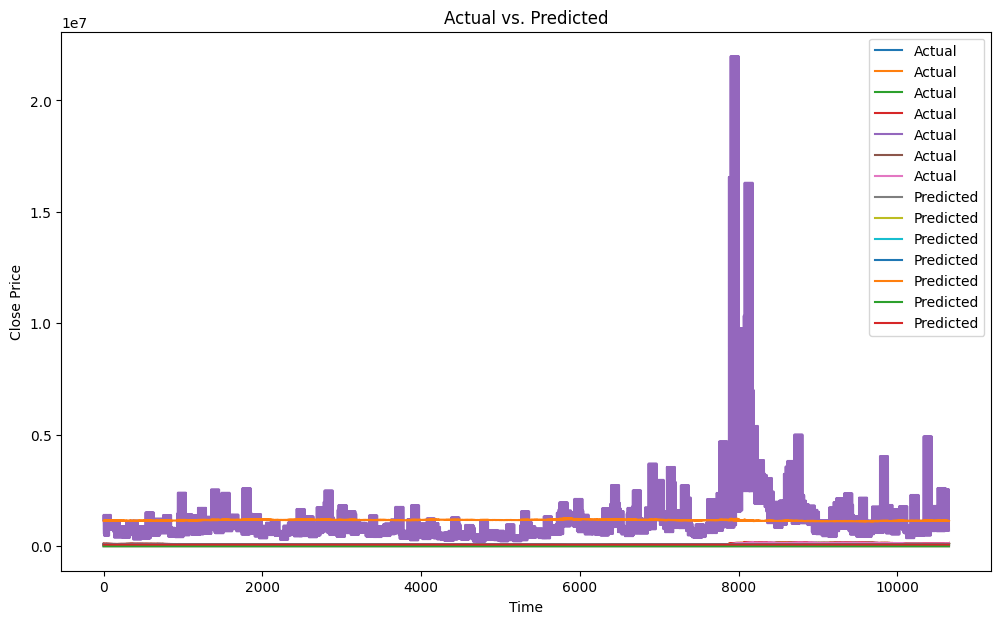

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                18432     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 7)                 231       
                                                                 
Total params: 20743 (81.03 KB)
Trainable params: 20743 (81.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
# 테스트 데이터를 사용하여 예측
y_pred = model.predict(X_test)

# 예측값을 스케일 역변환 (원래 스케일로 되돌리기)
y_pred = scaler.inverse_transform(y_pred)

# 원래 데이터와 예측값 비교
y_test_original = scaler.inverse_transform(y_test[:, -1])  # y_test를 1D로 변환
y_pred_original = y_pred  # y_pred의 형태가 이미 맞음

# 예측값과 실제값 비교 및 그래프 그리기
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(12, ln_use_cols))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

# 모델의 요약 정보 출력
model.summary()


In [105]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

input_use_col = ['Open', 'High', 'Low', ' Close','Volume', 'Change', 'ma20']
input_scaled = stock[input_use_col]

total_data =[[input_scaled[len(input_scaled)-WINDOW_SIZE:len(input_scaled)]]]
conform_total_data =[[input_scaled[len(input_scaled)-1:len(input_scaled)]]]
# print(total_data)
# print(conform_total_data)

# total_data를 2D 배열로 변환
data = np.array(total_data)
# 2D 배열을 리스트로 변환
data = data.tolist()

# 데이터만 포함된 행렬 생성
data = data[0]

# data_matrix 출력
# print(data)
# print(len(data[0]))
conform_data = conform_total_data[0][0] # 마지막 데이터를 변수에 할당
conform_data = conform_data.values[0]  # 데이터 확인용 
print(conform_data)


# 3D 배열을 2D로 변환
data_2d = np.array(data).reshape(-1, len(data[0][0]))  # 하위 리스트의 길이를 사용

# Min-Max 스케일러 생성
scaler = MinMaxScaler()
scaler.fit(data_2d)

# 주어진 데이터를 스케일링
scaled_data_2d = scaler.transform(data_2d)

# 2D 배열을 3D로 다시 변환
scaled_data_3d = scaled_data_2d.reshape(len(data), len(data[0]), len(data[0][0]))  # 원래 형태로 다시 변환

# 모델로부터의 예측 결과 (여기에서 모델 예측을 수행해야 함)
predicted_value = model.predict(scaled_data_3d)  # 모델에 스케일링된 데이터를 입력

# 예측값을 스케일링 전의 원래 값으로 역 스케일링
predicted_value_original = scaler.inverse_transform(predicted_value)
# print(predicted_value_original)
predicted_value_original = np.round(predicted_value_original, ln_use_cols)[0]
print(predicted_value_original)

# conform_data를 기준으로 predicted_value_original의 값을 백분율로 계산 후 절대값으로 만들기
percentage_diff = [abs(round((a - b) / b * 100, 2)) for a, b in zip(predicted_value_original, conform_data)]

print(percentage_diff)


[ 1.40000000e+05  1.40500000e+05  1.38000000e+05  1.38000000e+05
  7.03821000e+05 -1.77935943e-02  1.30450000e+05]
1/1 [==============================] - 0s 337ms/step
[ 1.30582797e+05  1.32634281e+05  1.29567375e+05  1.29861312e+05
  7.83532250e+05 -3.61429993e-03  1.26739492e+05]
[6.73, 5.6, 6.11, 5.9, 11.33, 79.69, 2.84]


1/1 [==============================] - 0s 311ms/step
Predicted Value: [[3.225136]]
